# Revisiting Food-Safety Inspections from the Chicago Dataset - A Tutorial

# Publication 1

## 1. Introduction

Foodborne illnesses afflict an estimated 48 million Americans each year, resulting in 128,000 hospitalizations and 3,000 fatalities [1]. City Governments curb the spread of illness by enforcing stringent food codes but often act under heavy resource constraints. Building on work by the City of Chicago, this tutorial seeks to develop a predictive model of food code violations that would help to safeguard public health by providing real-time risk analysis both to public officials and the facilities they inspect.

### 1.1. Past Work

In 2014 the Chicago Department of Public Health (CDPH) began working to develop a forecast for critical health code violations, the primary determinant of health and inspection outcomes [2][3]. After exploring a number of datasets and features, the team found the strongest predictors of critical violations to be the inspector assigned, previous inspection outcomes, age at inspection, licenses for alcohol or tobacco, the temperature at time of inspection, nearby burglaries, nearby sanitation complaints and nearby garbage cart requests.

Using a glmnet model trained on data from January 2011 through January 2014, the team was able to demonstrate that a data-driven inspections schedule could significantly reduce the time to find a critical violation. This model has since been adopted by the CDPH and serves as an excellent demonstration of the utility of such research.

### 1.2. Premise

In light of the CDPH's success we began this project intending to explore and extend their work. Whereas the Chicago team set out to predict critical violations, we are working to develop a series of models to forecast individual violations as well as to explore neural networks for the prediction model.

By developing a higher resolution model we hope to provide actionable information not just to public officials but to restaurants themselves. In addition to being generally interested in customers' health, restaurants are fined \$500 for each critical and $250 for each serious violation found, and so are highly motivated to maintain health codes. A real-time violation risk analysis could thus provide actionable information to restaurants on an ongoing basis, improving inspection outcomes and promoting public health.

## 2. Pre-processing and Data Structuring

While we may explore additional datasets as work progresses we decided to start by preparing those datasets that the Chicago team found to be significant, translating from R to Python and adapting code to our purposes as needed. 

The datasets used are as follows:
* [food inspections](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5/data)
* [business licenses](https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr/data)
* [garbage cart requests](https://www.cityofchicago.org/city/en/dataset/garbage_cart_stolenormissing.html)
* [sanitation code complaints](https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Sanitation-Code-Complaints/me59-5fac/data)
* [crimes](https://data.cityofchicago.org/Public-Safety/Crimes-2018/3i3m-jwuy/data)
* [weather](https://darksky.net/dev)

With the exception of weather data from darksky.net all data used is available through the [Chicago Data Portal](https://data.cityofchicago.org/). We will not be working with data on inspector assigned as this is not publicly available and would not be provide useful inisght in practice.

### 2.1. Preparation of Food Inspections Data

To download the inspections data we used Sodapy, a client for the Socrata Open Data API (the data platform used by the Chicago Data Portal):

In [184]:
import pandas as pd
import numpy as np

!pip install sodapy
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Conveniently,  Sodapy converts all columns to snake case, removes special characters and standardizes date format by default:

In [71]:
# First 50000 results, returned as JSON from API 
# Connverted to Python list of dictionaries by sodapy.
# Column names converted to snake case, special chars removed
# Dates and location formatted
results = client.get("4ijn-s7e5", limit=50000)

# Convert to pandas DataFrame
inspections = pd.DataFrame.from_records(results)

As Socrata restricts queries to 50000 entries we then paged through the remainder to access the full dataset: 

In [72]:
# Download remaining food inspections (limit 50000 / call)
start = 50000
while results:
    print(start)
    results = client.get("4ijn-s7e5", limit=50000, offset=start)
    inspections = inspections.append(pd.DataFrame.from_records(results))
    start += 50000

50000
100000
150000
200000


After exploring the data and reading through the CDPH's work in R we then applied a series of filters to produce a consistent and usable dataset:

In [73]:
# Remove trailing backslash (left over from sodapy conversion of "License #" column)
inspections.rename(columns={"license_": "license"}, inplace=True)

# Drop rows with missing data
inspections.dropna(subset=["inspection_date", "license", "latitude", "longitude"], inplace=True)

# Convert latitude and longitude to float
inspections.latitude = inspections.latitude.astype(float)
inspections.longitude = inspections.longitude.astype(float)

# Drop duplicates
inspections.drop_duplicates("inspection_id", inplace=True)

# Drop "0" licenses
inspections = inspections[inspections.license != "0"]

# Only consider successful inspections
inspections = inspections[~inspections.results.isin(["Out of Business", "Business Not Located", "No Entry"])]

In addition to semi-regular canvas inspections facilities may also be inspected due to complaints or a recent failed inspection. To ensure that our data is representative of restaurants operating as usual we filtered the dataset to consist only of canvas inspections:

In [74]:
# Only consider canvas inspections (not complaints or re-inspections)
inspections = inspections[inspections.inspection_type == "Canvass"]

We also filtered inspections by facility type, to eliminate the inconsistency of data from e.g. hospitals and schools which follow different inspection schedules:

In [75]:
# Only consider restaurants and grocery stores (subject to change)
inspections = inspections[inspections.facility_type.isin(["Restaurant", "Grocery Store"])]

Finally we saved the resulting dataframe as a CSV file, ready for later use:

In [76]:
import os.path
root_path = os.path.dirname(os.getcwd())

# Save result
# inspections.to_csv(os.path.join(root_path, "DATA/food_inspections.csv"), index=False)

### 2.2. Preparation of Remaining Socrata Data

The process of downloading and filtering business licenses, garbage cart requests, sanitation complaints and crimes was much the same as with food inspections - for specifics please see the [CODE folder of our project repository](https://github.com/Sustainabilist/ChicagoDataAnalysis/tree/master/CODE). 

In brief:
* All datasets were formatted by sodapy and filtered to remove duplicates and missing data.
* Crimes were filtered to include only burglaries since 2010 to reduce size and ensure consistency.
* Garbage cart requests and sanitation complaints were filtered to include only completed or open requests.

### 2.3. Preparation of Weather Data

The process of pulling the weather data from the [Darksky API](https://darksky.net/dev) was straightforward and can be found in notebook 16 in the CODE folder of our project repository. To eliminate redundant API calls, the script first imports any existing weather data and checks this data first before each request.

Each weather record consists of an inspection ID, a date, the pricipitation intensity, the maxiumum temperature, the windspeed and the humidity at that date. As the inspections region only measures some twenty miles across we used a single location in central Chicago for all weather records.

### 2.4. Calculation of Violations Data
Each entry in the violations column of the food inspections dataset is made up of a number of violation/comment pairs joined into a string:

In [79]:
inspections.iloc[2].violations

'31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVICE ARTICLES PROPERLY STORED: NO REUSE OF SINGLE SERVICE ARTICLES - Comments: OBSERVED THE KNIFES IMPROPERLY STORED BETWEEN  WALL AND PREP TABLE IN REAR AND IN FRONT BETWEEN TWO COOLERS, INSTRUCTED TO PROVIDE A KNIFE RACK FOR PROPER STORAGE.  | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED THE #10 CAN OPENER, AND THE FRONT CUTING BOARDS NOT CLEAN, INSTRUCTED TO CLEAN AND SANITIZE. ALSO CLEAN CHAR. GRILL DRIP TRAY. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: OBSERVED DUSTY CEILING VENTS, INSTRUCTED TO CLEAN.'

To make violations data more accessible we split each violations entry into a sequence of binary columns describing the presence of each violation:

In [80]:
# Split violations into binary values for each violation
def split_violations(violations):
    values_row = pd.Series([])
    
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            index = "v_" + violation.split('.')[0]
            values_row[index] = 1
    return values_row

In [81]:
# 5 mins
values_data = inspections.violations.apply(split_violations)

We then generated a series of column titles of the form "v_1" for violations 1-14 (critical), 15-29 (serious) and 30-44 plus 70 (minor):

In [82]:
# Generate column names
critical_columns = [("v_" + str(num)) for num in range(1, 15)]
serious_columns = [("v_" + str(num)) for num in range(15, 30)]
minor_columns = [("v_" + str(num)) for num in range(30, 45)]
minor_columns.append("v_70")

columns = critical_columns + serious_columns + minor_columns

These column headings were then combined with the violation values and paired with the inspection id for each row:

In [83]:
# Ensure no missing columns, fill NaN
values = pd.DataFrame(values_data, columns=columns).fillna(0)

values['inspection_id'] = inspections.inspection_id

We created a separate dataframe for critical, serious and minor violation counts by pairing each inspection id with the sum of the appropriate subset of violation values:

In [84]:
# Count violations
counts = pd.DataFrame({
    "critical_count": values[critical_columns].sum(axis=1),
    "serious_count": values[serious_columns].sum(axis=1),
    "minor_count": values[minor_columns].sum(axis=1)
})

counts['inspection_id'] = inspections.inspection_id

Lastly, we saved both datasets for later use:

In [85]:
# Save violation values and counts
values.to_csv(os.path.join(root_path, "DATA/violation_values.csv"), index=False)
counts.to_csv(os.path.join(root_path, "DATA/violation_counts.csv"), index=False)

## 3. Exploratory Analysis
Before proceeding to the selection and calculation of features we took some time for unstructured exploration to familiarize ourselves with the data.

### 3.1. Inspections Map
In order to improve our understanading of the inspections dataset and how it relates to other location-based data we used seaborn and folium to generate an inspections heat map:

In [87]:
!pip install folium

# Import necessary packages 
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [88]:
# Generate map
m = folium.Map([41.8600, -87.6298], zoom_start=10)

# Convert to (n, 2) nd-array format for heatmap
inspections_arr = inspections.sample(20000)[["latitude", "longitude"]].values

# Plot heatmap
m.add_child(plugins.HeatMap(inspections_arr.tolist(), radius=10))

### 3.2. Comments Word-cloud
To gain a sense of the feedback that facilities recieve alongside violations we concatenated all comments and used the resulting string to generate a word-cloud:

In [89]:
!pip install wordcloud
from wordcloud import WordCloud

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [96]:
# Extract comments from violations
def get_comments(violations):
    comments = ""
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            violation = violation.split('Comments:')
            if len(violation) == 2:
                comments += violation[1]
    return comments

In [97]:
# Concatenate all comments
comments_blob = inspections.violations.apply(get_comments).str.cat(sep=" ")

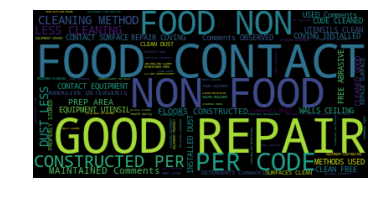

In [98]:
all_comments = inspections.violations.str.cat(sep=' ')

all_comments_wordcloud = WordCloud().generate(all_comments)
plt.imshow(all_comments_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Although qualitative, the results point to maintenence, food contact areas and non-food surfaces as common areas of concern.

### 3.4. Violations Chart

For a more quantitative perspective we used the violations data to generate a simple bar graph:

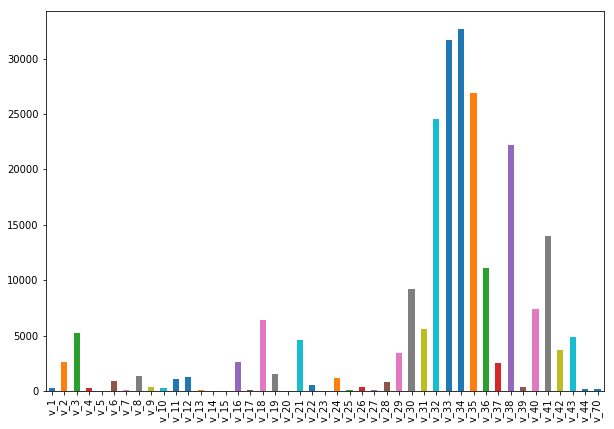

In [99]:
# Add up binary values for each violation column
violation_sums = values.drop(columns="inspection_id").sum()

violation_sums.plot(kind="bar", figsize=(10, 7))

As this chart makes clear, the vast majority of violations are minor (v_30+), with only a scattering of serious (v_15-29) and critical (v_1-14) violations.

Using an [online chart of the Chicago health code](https://webapps1.cityofchicago.org/healthinspection/Code_Violations.jsp) we determined that the most common violations pertain to cleanliness and maintenance of floors, walls and ceilings; sanitation and maintenance of utensils and equipment; proper venting; and proper organization of food and cleaning supplies.

The most common serious violation is improper control of vermin (v_18), and the most common critical violations relate to improper storage of hot and cold foods (v_2, v_3).

### ?. inspection history??? [ROUGH, MIGHT REMOVE]
The Chicago team found that one of the greatest predictors of critical violations and failed inspections was the establishment's recent inspection history. To investigate this, grouped inspections by license, shifted each group to find the previous inspection, and set up a crosstab (contingency?) table. We found that [RESULTS SEEM WEIRD, PROBABLY DON'T INCLUDE?]
* P(FAIL | FAIL) = .11
* p(fail | pass) = .25

### 3.5. Opportunity Research
Before investing time to develop a violations forecasting tool for restaurants and other facilities we wanted to assess whether such information would actually be valuable. For example, if businesses rarely fail inspections and generally do so in summer even perfect information would not provide much additional value. If on the other hand failed inspections are frequent and difficult to predict, such a forecast would be valuable and actionable.

To explore this we first grouped inspections by license (as all inspections for a facility share a common license). Then for each license group we determined the age, yearly inspections, failure rate and several other statistics:

In [168]:
# Convert inspection_date to datetime format
inspections["datetime"] = pd.to_datetime(inspections["inspection_date"])

# Calculate statistics for license groups
def get_stats(group):
    group.sort_values(by='datetime')

    inspections = len(group)
    fails = len(group[group['results'] == 'Fail'])
    most_recent = group.iloc[0].datetime
    days_old = (most_recent - group.iloc[-1].datetime).days + 1
    years_old = days_old / 365.25
    daily_inspections = inspections / days_old
    daily_fails = fails / days_old
    yearly_inspections = inspections / years_old
    yearly_fails = fails / years_old   
    failure_rate = fails / inspections
    return pd.Series({
        'inspections': inspections,
        'fails': fails,
        'most_recent': most_recent,
        'days_old': days_old,
        'years_old': years_old,
        'daily_inspections': daily_inspections,
        'daily_fails': daily_fails,
        'yearly_inspections': yearly_inspections,
        'yearly_fails': yearly_fails,
        'failure_rate': failure_rate
    })

# Group by license and apply get_stats
licenses = inspections.groupby('license').apply(get_stats).reset_index()

To begin we plotted the number licenses in each rounded age bracket. We found that after a huge number of licenses with only a single inspection (years_old = 0) the die off is gradual:

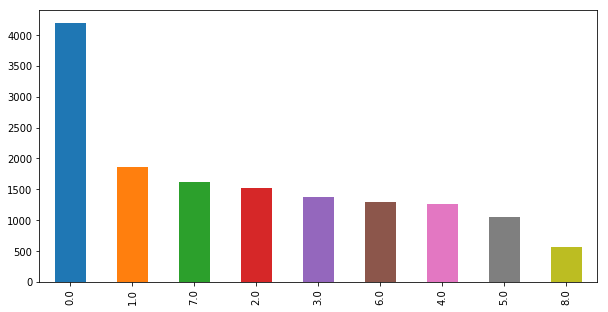

In [203]:
# Count restaurants in each rounded age bracket and plot
licenses.years_old.round().value_counts().plot(kind="bar", figsize=(10, 5))

To explore whether businesses experience enough failed inspections for risk analysis to be worthwhile we plotted the licenses in each yearly fails bracket. We found that outside of a huge number of with a 100% pass rate there is a gradual die-off in yearly fails:

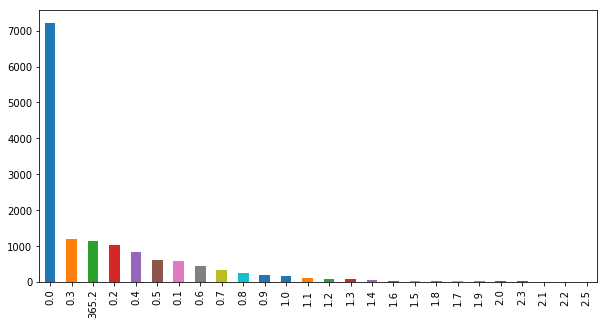

In [170]:
# Count restaurants in each rounded yearly fails bracket
yearly_fail_counts = licenses.yearly_fails.round(1).value_counts()

# Remove outliers and plot
yearly_fail_counts[yearly_fail_counts > 10].plot(kind="bar", figsize=(10, 5))

In [174]:
# Chart failure rate vs. age
pd.crosstab(licenses.years_old.round(), licenses.failure_rate.round(1))

failure_rate,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
years_old,,,,,,,,,,,
0.0,2947,0,1,0,0,85,0,0,0,0,1161
1.0,1050,1,4,106,0,540,0,35,0,0,129
2.0,740,0,105,258,4,190,5,125,15,0,72
3.0,626,2,283,125,47,158,26,51,34,0,30
4.0,522,30,330,106,84,92,44,23,21,0,16
5.0,344,74,233,132,95,71,45,30,24,0,7
6.0,385,202,276,177,102,65,35,34,15,6,3
7.0,446,380,317,190,139,63,46,18,10,4,3
8.0,146,152,113,66,54,23,6,4,2,1,0


Use of crosstab suggested a number of patterns
[INTERSPERSE WITH CROSSTAB]

For this exploration only current restauraants with an inspection history longer than 6 months were considered. Of these roughly 65% were inspected 1-2x/year and failed 0-.5x/year
[WHAT ABOUT PRIORITY?]

Looking at yearly fails vs years, most failed 0-.5x/year (including somewhat more established restaurants). Many failed .5-1.5x/year (including slightly more new restaurants). A smaller group failed 1.5x+ and were pretty much all new. This suggests a die-off, with resteraunts that fail more inspections not lasting as long.

Overall, it seems as though enough restaurants fail at least once a year that a predictive tool would be worthwhile (IS THAT THE CASE?).

## 5. Next Steps
[UNDECIDED]
* Kernel density estimation
* Selection of features
* Calculation of model data
* neural net for critical violations
* compare results to CDPH's model
* neural net for individual violations
* look at which things can actually be predicted and would provide actionable info
* develop forecast tool
* disseminate forecast tool

[1] https://www.cdc.gov/foodborneburden/index.html

[2] https://chicago.github.io/food-inspections-evaluation/

[3] https://github.com/Chicago/food-inspections-evaluatio]

## About the Authors
[NEEDS SOMETHING ABOUT JASON/SUSTAINABILIST?]
* David Lewis is a seasoned corporate responsibility professional working to utilize technology to help improve the health and well being of human populations through environmental stewardship. 
* Russell Hofvendahl is a developer and entreprenuer with a deep-seated love of data driven decision-making.

# Publication 2

## 1. In Review

## 2. Kernel Density Estimation
[HAVEN'T WRITTEN THE CODE FOR THIS]
* gaussian kde
* 90 day window
* heat map for garbage, crime, sanitation
* call something other than heat map to avoid confuion?

## 3. Calculation of Model Data
We then set out derive all features originally considered by the Chicago team plus several novel features, translating from R to Python in the process. While relative weights in forecasting individual violations rather than number of critical violations may be different, we expect the significant databases and [NEEDS REPHRASING & STUFF]

[MAYBE HAVE BULLET POINTS FOR DATABASES, FEATURES]

Each row of the final training dataset represents an inspection, its outcomes, and a number of other features. [SOMETHING ABOUT TRAINING METHODOLOGY, MAYBE ABOUT FIGURING OUT WHICH FEATURES MATTER FOR WHICH]

We used the inspections database as the basis for our training data.

List of features is as follows:

### 3.1. features from food inspection data
[NEED TO WRITE THIS UP]
* used subset of inspections as basis
* merged with violation values & counts on inspection id
* created pass / fail flags
* sorted by date, shifted to get previous info
  * past fail
  * past critical, serious, minor
  * inspections with no past default to 0
* calculate time since last
  * binary first_record
  * time since last defaults to 2
  
### 3.2. features from business license data
[YET TO BE CALCULATED]
  
### 3.3. from heat maps
[YET TO BE CALCULATED]
  
### 3.4. from weather
[YET TO BE CALCULATED

## 4. Generating Model